### Variable to calculate: surface Revelle factor

## Notebook for calculating GCB 2024 evaluation metric: Mean surface Revelle factor

- calculating from regridded sos, tos, dissicos, talkos, using mocsy 
- create yearly surface Revelle factor files (mocsy solver can't do full timeseries in one go), then concatenate.




In [1]:
%reset

In [2]:
import numpy as np
from cmocean import cm
import matplotlib.pyplot as plt
import xarray as xr
import sys

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/mocsy-master')
import mocsy
import numpy as np
print(mocsy)

import gsw
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

<module 'mocsy' from '/gpfs/home/mep22dku/scratch/SOZONE/mocsy-master/mocsy.cpython-37m-x86_64-linux-gnu.so'>


In [3]:
demo = True #mocsy demo
make = False #make yearly revelle factors
savenc = True #save revelle timeseries

## mocsy demo on one year of raw output data

<xarray.DataArray 'DIC' (time_counter: 12, deptht: 31, y: 149, x: 182)>
[10087896 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * deptht         (deptht) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) object 2020-01-16 12:00:00 ... 2020-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    long_name:           Dissolved inorganic Concentration
    units:               mol/L
    online_operation:    average
    interval_operation:  5760 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5760 s)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


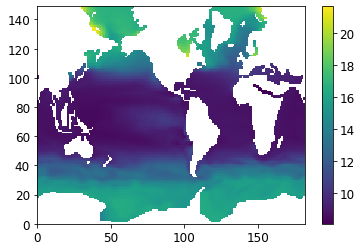

In [4]:
if demo:
    
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    gridT = xr.open_dataset('/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_GEA0/ORCA2_1m_20200101_20201231_grid_T.nc')
    ptrc = xr.open_dataset('/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_GEA0/ORCA2_1m_20200101_20201231_ptrc_T.nc')

    print(ptrc.DIC)

    tdra = np.ravel(ptrc.DIC[:,0,:,:].values * 1e3) #DIC, convert mol/L to mol/m3 (1000 L/m3)
    ttara = np.ravel(ptrc.Alkalini[:,0,:,:].values * 1e3) #Alkalinity, convert mol/L to mol/m3 (1000 L/m3)
    tsra = np.ravel(gridT.vosaline[:,0,:,:].values) #salt
    tsra_psu = np.ravel(gridT.vosaline[:,0,:,:].values) *35/35.16504 #g/kg to psu (salt)
    ttera = np.ravel(gridT.votemper[:,0,:,:].values)

    tdepth = np.zeros_like(ttera)
    tdepth[:] = tmesh.gdept_1d[0,0].values
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)



    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    BetaD = BetaD.reshape(12,149,182)
    BetaD[BetaD>100] = np.nan

    w = plt.pcolormesh(BetaD[0,:,:])
    plt.colorbar(w)


#### code to make intermediate revelle factor stuff (yearly files, calculating Revelle on the whole timeseries at once is too memory intensive)

In [5]:

def make_intermediate_Revelle(tsim, pwd = '/gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/',\
                              yrst = 1959, yrend = 2023):
    
    tfil = glob.glob(f'{pwd}dissicos_PlankTOM_{tsim}_1_gr_1959*.nc')
    dissicos = xr.open_dataset(tfil[0])
    tfil = glob.glob(f'{pwd}talkos_PlankTOM_{tsim}_1_gr_1959*.nc')
    talkos = xr.open_dataset(tfil[0])
    tfil = glob.glob(f'{pwd}sos_PlankTOM_{tsim}_1_gr_1959*.nc')
    sos = xr.open_dataset(tfil[0])
    tfil = glob.glob(f'{pwd}tos_PlankTOM_{tsim}_1_gr_1959*.nc')
    tos = xr.open_dataset(tfil[0])

    for yr in range(yrst,yrend+1):
        print(f'sim {tsim}, {yr}')

        DIC = dissicos.dissicos.sel(TIME=slice(f'{yr}-01-01', f'{yr+1}-01-01'))
        TA = talkos.talkos.sel(TIME=slice(f'{yr}-01-01', f'{yr+1}-01-01'))
        salt = sos.sos.sel(TIME=slice(f'{yr}-01-01', f'{yr+1}-01-01'))
        temp = tos.tos.sel(TIME=slice(f'{yr}-01-01', f'{yr+1}-01-01'))

        tdra = np.ravel(DIC.values) #DIC, mol/m3
        ttara = np.ravel(TA.values) #Alkalinity, mol/m3 
        tsra = np.ravel(salt.values)
        tsra_psu = tsra *35/35.16504 #g/kg to psu (salt)
        ttera = np.ravel(temp.values) 

        tdepth = np.zeros_like(ttera)
        ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
        tzero = np.zeros_like(tdepth)
        tpressure = np.zeros_like(tdepth) 
        tpressure[:] = 1

        response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                           sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
        pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

        BetaD = BetaD.reshape(12,180,360)
        BetaD[BetaD>100] = np.nan

        plt.figure()
        w = plt.pcolormesh(BetaD[0,:,:])
        plt.colorbar(w)

        outputFile = f'/gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateRevelledata/Revelle_PlankTOM_RIV12_{tsim}_1_gr_{yr}.nc'
        data_vars = {'RevelleF':(['TIME', 'LATITUDE', 'LONGITUDE'], BetaD,
        {'units': 'unitless',
        'long_name':'Revelle Factor, BetaD from mocsy'}),
        }
        # define coordinates
        coords = {'TIME': (['TIME'], DIC.TIME),
                  'LATITUDE': (['LATITUDE'], DIC.LATITUDE),
                'LONGITUDE': (['LONGITUDE'], DIC.LONGITUDE),
        }
        # define global attributes
        attrs = {'made in':'/gpfs/data/greenocean/GCB/GCB2024/scripts/makeRevelle.ipynb',
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(outputFile)

In [6]:

if make:
    make_intermediate_Revelle('A')
    make_intermediate_Revelle('B')
    make_intermediate_Revelle('C')
    make_intermediate_Revelle('D')

## open all the Revelle files as an mfdataset and save

In [10]:
resultsdir = '/gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/'
yrFrom = 1959
yrTo = 2023

In [11]:
def make_yearlist_intRevelle(yrst, yrend, tr):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateRevelledata/Revelle_PlankTOM_RIV12_{tr}_1_gr_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

if savenc:
    ylist_A = make_yearlist_intRevelle(1959,2023,'A')
    so_A = xr.open_mfdataset(ylist_A)
    ylist_B = make_yearlist_intRevelle(1959,2023,'B')
    so_B = xr.open_mfdataset(ylist_B)
    ylist_C = make_yearlist_intRevelle(1959,2023,'C')
    so_C = xr.open_mfdataset(ylist_C)
    ylist_D = make_yearlist_intRevelle(1959,2023,'D')
    so_D = xr.open_mfdataset(ylist_D)

In [12]:
import arrow
utc = arrow.utcnow()
timestamp = utc.format('YYYYMMDD')
parm = 'Revelle'


if savenc:
    
    simulationID = 'A'
    outputFile = f'{resultsdir}{parm}_PlankTOM_{simulationID}_1_gr_{yrFrom}-{yrTo}_v{timestamp}.nc'
    so_A.to_netcdf(outputFile)
    
    simulationID = 'B'
    outputFile = f'{resultsdir}{parm}_PlankTOM_{simulationID}_1_gr_{yrFrom}-{yrTo}_v{timestamp}.nc'
    so_B.to_netcdf(outputFile)
    
    simulationID = 'C'
    outputFile = f'{resultsdir}{parm}_PlankTOM_{simulationID}_1_gr_{yrFrom}-{yrTo}_v{timestamp}.nc'
    so_C.to_netcdf(outputFile)
    
    simulationID = 'D'
    outputFile = f'{resultsdir}{parm}_PlankTOM_{simulationID}_1_gr_{yrFrom}-{yrTo}_v{timestamp}.nc'
    so_D.to_netcdf(outputFile)

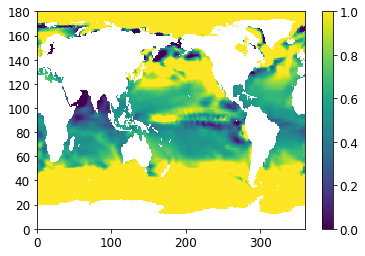

In [13]:
x = so_A.isel(TIME = 700).RevelleF.values
y = so_A.isel(TIME = 0).RevelleF.values
q = plt.pcolormesh(x-y, vmin = 0, vmax = 1)
plt.colorbar(q)